# 0- Import packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import numpy as np

import time

# 1- Import data

In [4]:
torch.backends.cudnn.deterministic = True
LABEL = data.LabelField(dtype = torch.float)
TEXT = data.Field(tokenize = 'spacy')
fields = [(None, None),(None, None), (None, None), (None, None),(None, None),(None, None), ('label', LABEL),(None, None),(None, None), (None, None),(None, None),('text',TEXT)]
train_data = data.TabularDataset(path = 'data/data_filtered2_balanced_all.csv', format = 'csv', fields = fields, skip_header = True)
print(f'Number of data examples: {len(train_data)}')

train_data, test_data = train_data.split(0.8)
train_data, valid_data = train_data.split(0.8)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of data examples: 98474
Number of training examples: 63023
Number of validation examples: 15756
Number of testing examples: 19695


# 2- Build vocabulary

In [5]:
MAX_VOCAB_SIZE = 95_000 #most common 25000 words
LABEL.build_vocab(train_data)
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

print(f"Most common words: {TEXT.vocab.freqs.most_common(20)}") #most common words
print(f"Vocabulary:{TEXT.vocab.itos[:10]}") #to see vocabulary
print(f"Labels: {LABEL.vocab.stoi}") #to see labels

Unique tokens in TEXT vocabulary: 91313
Unique tokens in LABEL vocabulary: 2
Most common words: [('.', 295451), (',', 235065), ('the', 216949), ('I', 198435), ('and', 154310), ('a', 144657), ('to', 130237), (' ', 124001), ('it', 108523), ('of', 105632), ('is', 92011), ('in', 67634), ('this', 66369), ('for', 64613), ('that', 58812), ('was', 44797), ('my', 44392), ('you', 44025), ('with', 42871), ('not', 42395)]
Vocabulary:['<unk>', '<pad>', '.', ',', 'the', 'I', 'and', 'a', 'to', ' ']
Labels: defaultdict(<function _default_unk_index at 0x00000135F95551E0>, {'0': 0, '1': 1})


# 3- Build iterators

In [6]:
BATCH_SIZE = 32 #64, does not work with 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

''''train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)'''

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: x.text, #sort by s attribute (quote)
    sort_within_batch=False,
    batch_size=BATCH_SIZE,
    device=device)

# 4- Build the model

In [7]:
#1- Define the model

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))
    
#2- Create an instance of the RNN class
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

#3- Function to know how many trainable parameters
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 4,626,551 trainable parameters


# 5 - Train the model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


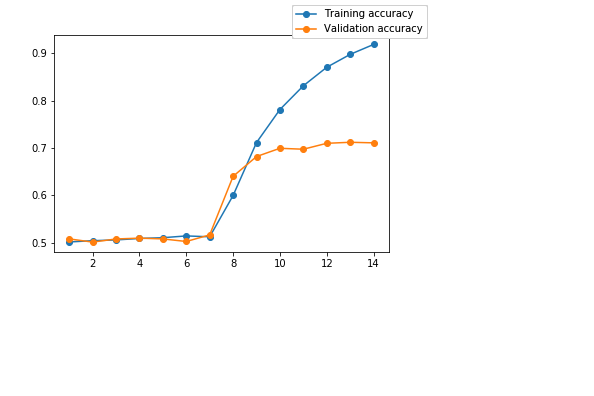

<IPython.core.display.Javascript object>


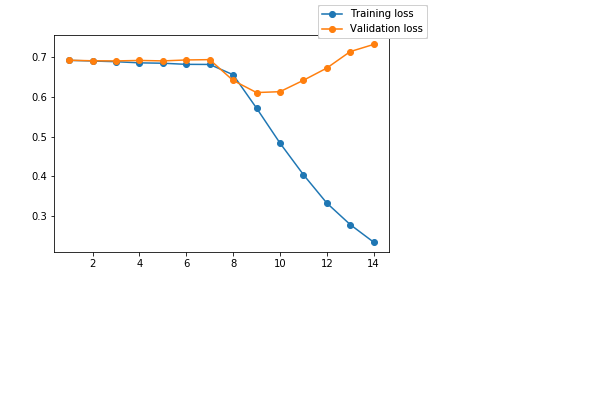

Epoch: 01 | Epoch Time: 2m 38s
	Train Loss: 0.693 | Train Acc: 50.16%
	 Val. Loss: 0.693 |  Val. Acc: 50.81%


C:\Users\arrij\Anaconda3\New folder\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Epoch: 02 | Epoch Time: 2m 45s
	Train Loss: 0.691 | Train Acc: 50.43%
	 Val. Loss: 0.692 |  Val. Acc: 50.13%
Epoch: 03 | Epoch Time: 2m 43s
	Train Loss: 0.689 | Train Acc: 50.59%
	 Val. Loss: 0.691 |  Val. Acc: 50.79%
Epoch: 04 | Epoch Time: 2m 41s
	Train Loss: 0.686 | Train Acc: 50.90%
	 Val. Loss: 0.692 |  Val. Acc: 50.97%
Epoch: 05 | Epoch Time: 2m 40s
	Train Loss: 0.685 | Train Acc: 51.06%
	 Val. Loss: 0.691 |  Val. Acc: 50.80%
Epoch: 06 | Epoch Time: 2m 42s
	Train Loss: 0.683 | Train Acc: 51.44%
	 Val. Loss: 0.694 |  Val. Acc: 50.26%
Epoch: 07 | Epoch Time: 2m 40s
	Train Loss: 0.682 | Train Acc: 51.25%
	 Val. Loss: 0.694 |  Val. Acc: 51.65%
Epoch: 08 | Epoch Time: 2m 42s
	Train Loss: 0.656 | Train Acc: 59.97%
	 Val. Loss: 0.642 |  Val. Acc: 64.01%
Epoch: 09 | Epoch Time: 2m 42s
	Train Loss: 0.572 | Train Acc: 71.14%
	 Val. Loss: 0.611 |  Val. Acc: 68.19%
Epoch: 10 | Epoch Time: 2m 41s
	Train Loss: 0.484 | Train Acc: 78.12%
	 Val. Loss: 0.614 |  Val. Acc: 69.93%
Epoch: 11 | Epoch T

KeyboardInterrupt: 

In [11]:
#0- Set up the plotting figure
%matplotlib inline
%config InlineBackend.figure_format ='svg'
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#1- Set up the optimizer

#optimizer = optim.SGD(model.parameters(), lr=1e-1)
optimizer = optim.Adam(model.parameters())

#2- Sigmoid and boundary cross entropy
criterion = nn.BCEWithLogitsLoss()

#3- Move them to GPU
model = model.to(device)
criterion = criterion.to(device)

#4- Accuracy function
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

#5- Train function
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#6- Evaluate function
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#7- Epoch running time function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#8- Train the model
N_EPOCHS = 200

best_valid_loss = float('inf')
cont = -1
train_loss_vec = np.zeros(N_EPOCHS)
valid_loss_vec = np.zeros(N_EPOCHS)
train_acc_vec = np.zeros(N_EPOCHS)
valid_acc_vec = np.zeros(N_EPOCHS)

best_valid_loss = float('inf')

fig1 = plt1.figure()
ax1 = fig1.add_subplot(111)
fig1.show()
fig1.canvas.draw()

fig2 = plt2.figure()
ax2 = fig2.add_subplot(111)
fig2.show()
fig2.canvas.draw()

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    cont = cont + 1
    train_loss_vec[cont]=train_loss
    valid_loss_vec[cont]=valid_loss
    train_acc_vec[cont]=train_acc
    valid_acc_vec[cont]=valid_acc
    
    ax1.clear()
    ax1.plot(range(1,epoch+2),train_acc_vec[0:cont+1],'-o', label=r'Training accuracy') 
    ax1.plot(range(1,epoch+2),valid_acc_vec[0:cont+1],'-o', label=r'Validation accuracy')
    fig1.legend(loc='best')
    fig1.canvas.draw()
    
    ax2.clear()
    ax2.plot(range(1,epoch+2),train_loss_vec[0:cont+1],'-o', label=r'Training loss') 
    ax2.plot(range(1,epoch+2),valid_loss_vec[0:cont+1],'-o', label=r'Validation loss')
    fig2.legend(loc='best')
    fig2.canvas.draw()

# 6- Final results

In [12]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.607 | Test Acc: 68.56%
